## Preliminaries

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

In [2]:
# Load in datasets
df_red = pd.read_csv("winequality-red.csv", sep=";")
df_white = pd.read_csv("winequality-white.csv", sep=";")

# Add color column (red = 1, white = 0)
df_white["color"] = 0
df_red["color"] = 1

# Concatenate dataframes
df = pd.concat([df_red, df_white])

# Get explanatory variables (all but quality)
df_ev = df.loc[:, df.columns != 'quality']

# Get quality variable
df_quality = df.loc[:, df.columns == 'quality']

## Question 1

In [3]:
# Heatmap
heatmap = df.corr().style.background_gradient(cmap='coolwarm')
heatmap

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


In [4]:
# Note which variables have the highest absolute correlation with quality
df.corr()["quality"].sort_values(ascending=False)

,quality
quality,1.000000
alcohol,0.444319
citric acid,0.085532
free sulfur dioxide,0.055463
sulphates,0.038485
pH,0.019506
residual sugar,-0.036980
total sulfur dioxide,-0.041385
fixed acidity,-0.076743
color,-0.119323


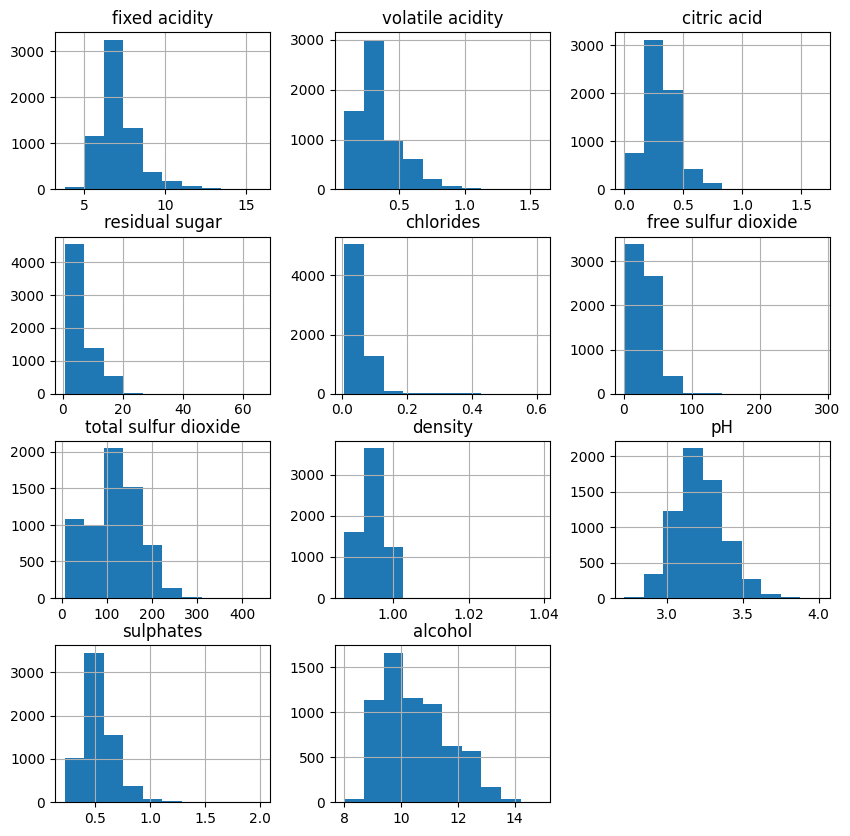

In [5]:
# Histogram of numerical features
df_numerical_ev = df_ev.loc[:, df_ev.columns != 'color'] # Get all but color
df_numerical_ev.hist(figsize=(10,10))
plt.show()

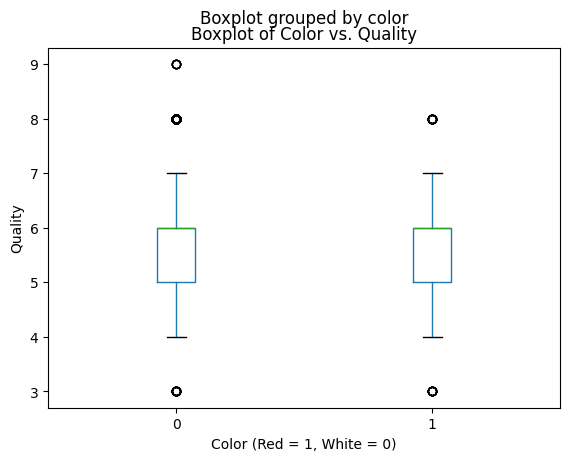

In [6]:
# Boxplot of color vs. quality
df_color_quality = pd.concat([df_ev["color"], df_quality], axis=1)
df_color_quality.boxplot(by="color")

# Remove gridlines
plt.grid(False)

# Add title
plt.title("Boxplot of Color vs. Quality")
plt.xlabel("Color (Red = 1, White = 0)")
plt.ylabel("Quality")
plt.show()

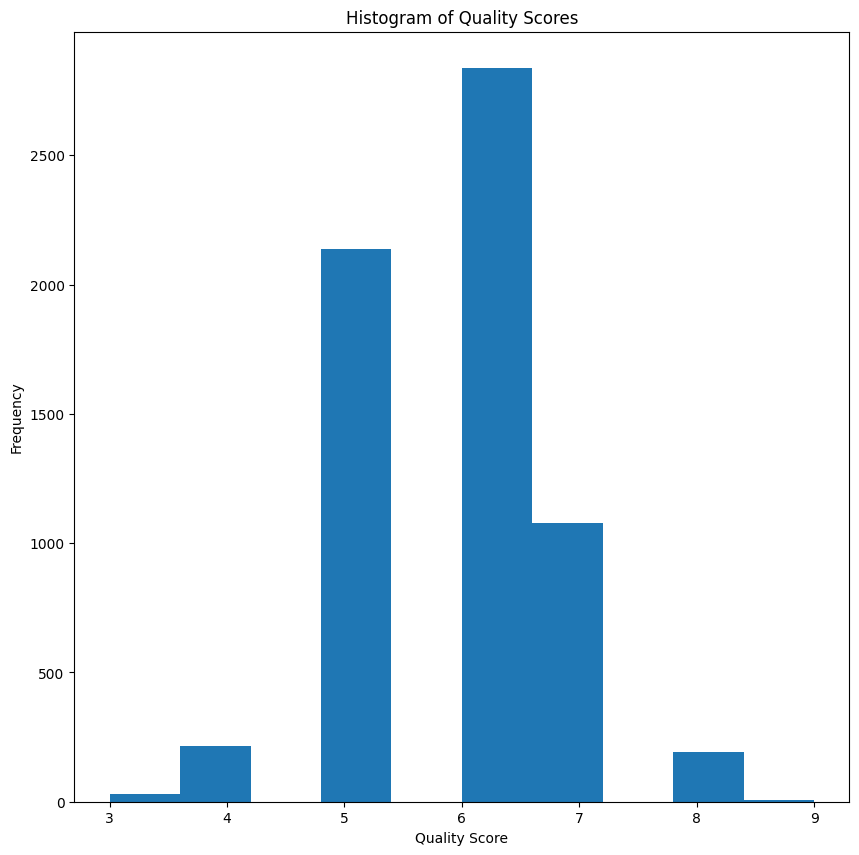

In [7]:
# Histogram of quality scores
df_quality.hist(figsize=(10,10))
plt.title("Histogram of Quality Scores")
plt.xlabel("Quality Score")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

## Question 2

In [8]:
# Standardize features
scaler = StandardScaler()
df_ev_scaled = scaler.fit_transform(df_ev)
df_ev_scaled = pd.DataFrame(df_ev_scaled, columns=df_ev.columns)

In [9]:
# Select features based on mutual information regression
mi_scores = mutual_info_regression(df_ev_scaled, df_quality)
mi_scores = pd.Series(mi_scores, index=df_ev.columns)
mi_scores.sort_values(ascending=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
alcohol,0.159045
density,0.158830
total sulfur dioxide,0.085155
chlorides,0.078524
residual sugar,0.073536
volatile acidity,0.071212
citric acid,0.050633
free sulfur dioxide,0.035865
fixed acidity,0.030029
sulphates,0.028516


In [10]:
# Use f regression
f_scores = f_regression(df_ev_scaled, df_quality)
f_scores = pd.Series(f_scores[0], index=df_ev.columns)
f_scores.sort_values(ascending=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
alcohol,1597.640584
density,670.307800
volatile acidity,493.351120
chlorides,272.504696
color,93.811807
citric acid,47.865475
fixed acidity,38.479055
free sulfur dioxide,20.041250
total sulfur dioxide,11.143435
sulphates,9.634206


For the models, we will use only the top five features for mutual information.

In [13]:
# Get top five features based on mutual information
top_five_mi = mi_scores.nlargest(5)

# Subset df_ev for top five features
df_ev_top_five_mi = df_ev[top_five_mi.index]

# Standardize features
scaler = StandardScaler()
df_ev_top_five_mi_scaled = scaler.fit_transform(df_ev_top_five_mi)
df_ev_top_five_mi_scaled = pd.DataFrame(df_ev_top_five_mi_scaled, columns=df_ev_top_five_mi.columns)
# df_ev_top_five_mi_scaled.head()

## Question 3

(See objective functions in write-up)

## Question 4

In [15]:
from re import X
# Perform 10-fold CV for OLS Regression
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store results
ols_rmse_list = []

for train_index, test_index in kf.split(df_ev_top_five_mi_scaled):

    # Split data for each fold
    X_train, X_test = df_ev_top_five_mi_scaled.iloc[train_index], df_ev_top_five_mi_scaled.iloc[test_index]
    y_train, y_test = df_quality.iloc[train_index], df_quality.iloc[test_index]

    # OLS model
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    ols_rmse_list.append(rmse)

# Display results
print("OLS RMSE:", np.mean(ols_rmse_list))

OLS RMSE: 0.7709001040432232


In [16]:
# Test different penalties for Lasso regression and perform 10-fold cv
penalties = [0.01, 0.1, 1, 10, 100]
lasso_rmse_list = []

for penalty in penalties:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    lasso_rmse_list = []
    for train_index, test_index in kf.split(df_ev_top_five_mi_scaled):
      # Split data for each fold
      X_train, X_test = df_ev_top_five_mi_scaled.iloc[train_index], df_ev_top_five_mi_scaled.iloc[test_index]
      y_train, y_test = df_quality.iloc[train_index], df_quality.iloc[test_index]

      # Lasso regression
      lasso = Lasso(alpha=penalty)
      lasso.fit(X_train, y_train)
      y_pred = lasso.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)
      lasso_rmse_list.append(rmse)

    print("Lasso RMSE with penalty", penalty, ":", np.mean(lasso_rmse_list))

Lasso RMSE with penalty 0.01 : 0.7711962948829696
Lasso RMSE with penalty 0.1 : 0.7881377835890475
Lasso RMSE with penalty 1 : 0.8729004699875558
Lasso RMSE with penalty 10 : 0.8729004699875558
Lasso RMSE with penalty 100 : 0.8729004699875558


In [17]:
# Test different penalties for Ridge regression and perform 10-fold cv
penalties = [0.01, 0.1, 1, 10, 100]
ridge_rmse_list = []

for penalty in penalties:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_rmse_list = []
    for train_index, test_index in kf.split(df_ev_top_five_mi_scaled):
        # Split data for each fold
        X_train, X_test = df_ev_top_five_mi_scaled.iloc[train_index], df_ev_top_five_mi_scaled.iloc[test_index]
        y_train, y_test = df_quality.iloc[train_index], df_quality.iloc[test_index]

        # Ridge regression
        ridge = Ridge(alpha=penalty)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        ridge_rmse_list.append(rmse)

    print("Ridge RMSE with penalty", penalty, ":", np.mean(ridge_rmse_list))

Ridge RMSE with penalty 0.01 : 0.7709001025983917
Ridge RMSE with penalty 0.1 : 0.7709000896397954
Ridge RMSE with penalty 1 : 0.7708999644945974
Ridge RMSE with penalty 10 : 0.7708991542336971
Ridge RMSE with penalty 100 : 0.7709324426314252


In [18]:
# Test different penalties for Ridge regression and perform 10-fold cv with unscaled data
penalties = [0.01, 0.1, 1, 10, 100]
ridge_rmse_list = []

for penalty in penalties:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_rmse_list = []
    for train_index, test_index in kf.split(df_ev_top_five_mi):

        # Split data for each fold
        X_train, X_test = df_ev_top_five_mi.iloc[train_index], df_ev_top_five_mi.iloc[test_index]
        y_train, y_test = df_quality.iloc[train_index], df_quality.iloc[test_index]

        # Ridge regression
        ridge = Ridge(alpha=penalty)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        ridge_rmse_list.append(rmse)

    print("Ridge RMSE with penalty", penalty, ":", np.mean(ridge_rmse_list))



Ridge RMSE with penalty 0.01 : 0.7710779046085758
Ridge RMSE with penalty 0.1 : 0.7717683485233597
Ridge RMSE with penalty 1 : 0.7720343967807538
Ridge RMSE with penalty 10 : 0.7726010411173176
Ridge RMSE with penalty 100 : 0.7733248280177354


## Question 5

In [19]:
# Perform polynomial regression with 10-fold cv
kf = KFold(n_splits=10, shuffle=True, random_state=42)
y = df_quality.values.ravel()

# Test different penalties and degrees
penalties = [0.01, 0.1, 1, 10, 100]
degrees = [2, 3, 4, 5, 6]

# Store RMSE values
poly_rmse_list = []

for penalty in penalties:
    for degree in degrees:
        rmse_list = []
        for train_index, test_index in kf.split(df_quality):
          # Split data for each fold
          X_train, X_test = df_ev_top_five_mi_scaled.iloc[train_index], df_ev_top_five_mi_scaled.iloc[test_index]
          y_train, y_test = y[train_index], y[test_index]

          # Polynomial transformation
          poly = PolynomialFeatures(degree=degree)
          X_train_poly = poly.fit_transform(X_train)
          X_test_poly = poly.transform(X_test)

          # Ridge regression
          ridge_poly = Ridge(alpha=penalty)
          ridge_poly.fit(X_train_poly, y_train)
          y_pred_poly = ridge_poly.predict(X_test_poly)
          mse_poly = mean_squared_error(y_test, y_pred_poly)
          rmse_poly = np.sqrt(mse_poly)
          rmse_list.append(rmse_poly)

        print("RMSE for polynomial regression with penalty", penalty, "and degree", degree, ":", np.mean(rmse_list))

RMSE for polynomial regression with penalty 0.01 and degree 2 : 0.7606054072035952
RMSE for polynomial regression with penalty 0.01 and degree 3 : 0.8576940518520286
RMSE for polynomial regression with penalty 0.01 and degree 4 : 5.974226448842964
RMSE for polynomial regression with penalty 0.01 and degree 5 : 82.6508749199219


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.40595e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.40298e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.62122e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.41057e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

RMSE for polynomial regression with penalty 0.01 and degree 6 : 824.263188440095
RMSE for polynomial regression with penalty 0.1 and degree 2 : 0.7606054235044817
RMSE for polynomial regression with penalty 0.1 and degree 3 : 0.8578047250203857
RMSE for polynomial regression with penalty 0.1 and degree 4 : 6.046539115650594
RMSE for polynomial regression with penalty 0.1 and degree 5 : 80.3465050208309


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.99335e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.87463e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.32931e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.13229e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

RMSE for polynomial regression with penalty 0.1 and degree 6 : 382.3417126226189
RMSE for polynomial regression with penalty 1 and degree 2 : 0.7606056457439528
RMSE for polynomial regression with penalty 1 and degree 3 : 0.8588873398357816
RMSE for polynomial regression with penalty 1 and degree 4 : 6.474549354663887
RMSE for polynomial regression with penalty 1 and degree 5 : 67.27039744874631
RMSE for polynomial regression with penalty 1 and degree 6 : 462.6188565826901
RMSE for polynomial regression with penalty 10 and degree 2 : 0.760613169189151
RMSE for polynomial regression with penalty 10 and degree 3 : 0.8677916241102022
RMSE for polynomial regression with penalty 10 and degree 4 : 6.45425563325265
RMSE for polynomial regression with penalty 10 and degree 5 : 29.90737328486274
RMSE for polynomial regression with penalty 10 and degree 6 : 834.9564252285579
RMSE for polynomial regression with penalty 100 and degree 2 : 0.7609245325361952
RMSE for polynomial regression with pena

## Question 6

In [23]:
# Choice of hyperparameters
hidden_layer_sizes = [(100, 50), (50, 25), (100, 50, 25)]
activation = ['identity', 'relu']
alpha = [0.0001, 0.001, 0.01]

# Perform k-fold cv
kf = KFold(n_splits=10, shuffle=True, random_state=42)
y = df_quality.values.ravel()

# Test different hyperparameters (about 10 minutes to run)
rmse_list = []

for hidden_layer_size in hidden_layer_sizes:
    for act in activation:
        for a in alpha:
            rmse_list = []
            for train_index, test_index in kf.split(df_quality):
              X_train, X_test = df_ev_top_five_mi_scaled.iloc[train_index], df_ev_top_five_mi_scaled.iloc[test_index]
              y_train, y_test = y[train_index], y[test_index]
              nn = MLPRegressor(hidden_layer_sizes=hidden_layer_size, activation=act, alpha=a, max_iter=1000, random_state=42)
              nn.fit(X_train, y_train)
              y_pred_nn = nn.predict(X_test)
              mse_nn = mean_squared_error(y_test, y_pred_nn)
              rmse_nn = np.sqrt(mse_nn)
              rmse_list.append(rmse_nn)

            print("RMSE for neural network with hidden layer sizes", hidden_layer_size, "activation function", act, "and alpha", a, ":", np.mean(rmse_list))

RMSE for neural network with hidden layer sizes (100, 50) activation function identity and alpha 0.0001 : 0.7730285444352828
RMSE for neural network with hidden layer sizes (100, 50) activation function identity and alpha 0.001 : 0.7730279451630284
RMSE for neural network with hidden layer sizes (100, 50) activation function identity and alpha 0.01 : 0.7730219855994486
RMSE for neural network with hidden layer sizes (100, 50) activation function relu and alpha 0.0001 : 0.746822653434036
RMSE for neural network with hidden layer sizes (100, 50) activation function relu and alpha 0.001 : 0.7488624815810575
RMSE for neural network with hidden layer sizes (100, 50) activation function relu and alpha 0.01 : 0.7471559590688044
RMSE for neural network with hidden layer sizes (50, 25) activation function identity and alpha 0.0001 : 0.7715996533544809
RMSE for neural network with hidden layer sizes (50, 25) activation function identity and alpha 0.001 : 0.7715995097919117
RMSE for neural networ

## Question 7

In [ ]:
# Use random forest to predict quality
rf = RandomForestRegressor(n_estimators=100, random_state=42, oob_score = True)
rf.fit(df_red_ev_scaled, df_red_quality)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(oob_score=True, random_state=42)

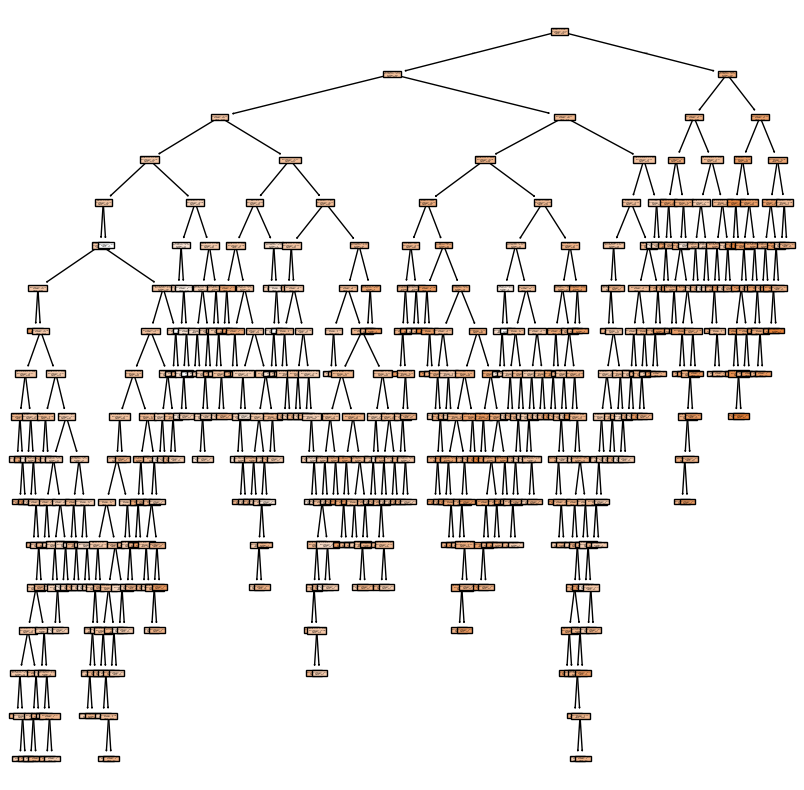

In [ ]:
# Plot structure of tree (~10s in current iteration)
plt.figure(figsize=(10,10))
plot_tree(rf.estimators_[0], feature_names=df_red_ev.columns, filled=True)
plt.show()

In [ ]:
# Get OOB error and R2 score
print("OOB error:", rf.oob_score_)
print("R2 score:", rf.score(df_red_ev_scaled, df_red_quality))

OOB error: 0.4985192896081798
R2 score: 0.9305608105869941


## Question 7

In [ ]:
# TODO